### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import tensorflow_hub as hub

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=100

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1919 files belonging to 9 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bhimsen_Temple',
 'Char_Narayan_Temple',
 'Dhungey_Dhara',
 'Garuda_Pillar',
 'Harishankara_temple',
 'Krishna_Mandir',
 'Narayan_Temple',
 'Octagonal_Chyasing_Deval',
 'Vishwanath_Temple']

In [6]:
n_classes=len(class_names)
n_classes

9

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0])

(32, 128, 128, 3)
[4 8 2 1 3 4 4 0 6 4 6 4 4 0 0 6 7 7 4 6 0 7 7 5 6 5 5 4 0 8 3 8]
tf.Tensor(
[[[225.61719  226.61719  228.61719 ]
  [226.38281  227.38281  229.38281 ]
  [227.4375   228.4375   230.4375  ]
  ...
  [176.71875  107.66406  109.03906 ]
  [108.21875   23.71875   31.59375 ]
  [ 98.16406   26.539062  29.914062]]

 [[227.23438  228.23438  230.23438 ]
  [227.07031  228.07031  230.07031 ]
  [227.17188  228.17188  230.17188 ]
  ...
  [151.39844   67.90625   76.69531 ]
  [130.36719   46.34375   50.664062]
  [103.72656   29.164062  31.851562]]

 [[226.47656  227.47656  229.47656 ]
  [228.21875  229.21875  231.21875 ]
  [228.57031  229.57031  231.57031 ]
  ...
  [149.51562   46.867188  65.953125]
  [130.32812   43.414062  52.414062]
  [ 90.75781   17.070312  20.632812]]

 ...

 [[210.       215.       221.      ]
  [207.96094  212.96094  218.96094 ]
  [212.60156  217.60156  221.60156 ]
  ...
  [178.47656  152.47656  119.47656 ]
  [146.75     119.49219   90.828125]
  [126.75781  101.

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

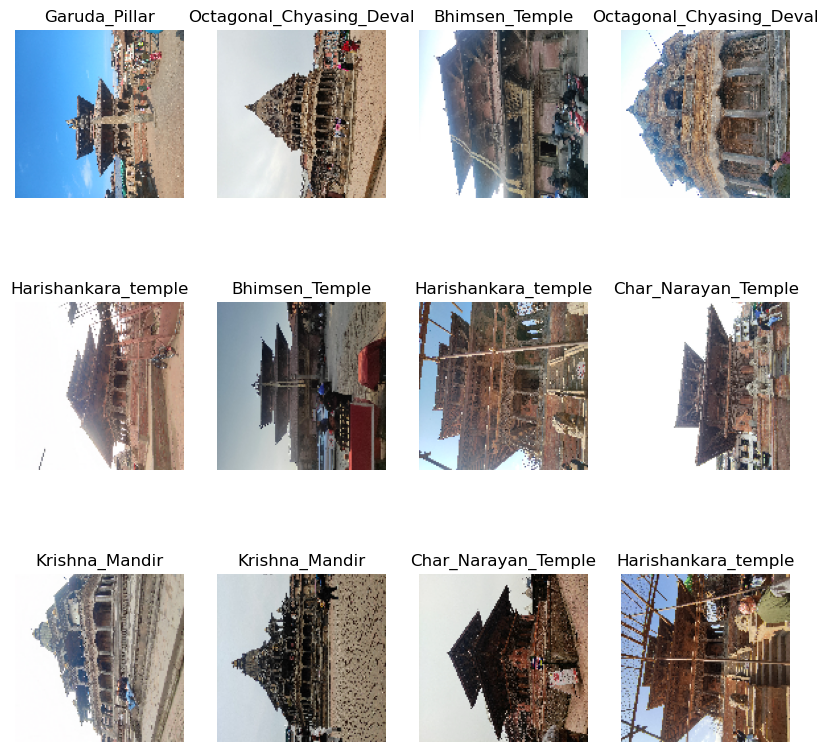

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

60

In [10]:
train_size = 0.8
len(dataset)*train_size

48.0

In [11]:
train_ds = dataset.take(15)
len(train_ds)

15

In [12]:
test_ds = dataset.skip(15)
len(test_ds)

45

In [13]:
val_size=0.1
len(dataset)*val_size

6.0

In [14]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [15]:
test_ds = test_ds.skip(1)
len(test_ds)

44

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

48

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

6

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomZoom(0.2),
#     layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    ])


#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

##Now take pre-trained model and retrain it using monuments images

In [25]:
feature_extractor_model ="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape= (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), trainable=False)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    pretrained_model_without_top_layer, 
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(60, activation='relu'),
    
    layers.Dense(30, activation='relu'),
    
    layers.Dense(18, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
])


In [27]:
#model.build()

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 60)               

In [29]:
# Get and print the weights of each layer
for layer in model.layers:
    if layer.get_weights():
        print(f"\nLayer: {layer.name}")
        weights = layer.get_weights()
        print(f"Weights:\n{weights}")
        
        # Check if biases exist
        if len(weights) > 1:
            biases = weights[1]
            print(f"Biases:\n{biases}")


Layer: keras_layer
Weights:
[array([[[[-2.69158870e-01,  8.65957048e-03, -2.40037894e-23,
          -3.73629987e-01, -8.38040039e-02, -3.97553414e-01,
          -8.82432014e-02, -2.70130157e-01,  5.13027050e-02,
          -3.79616916e-02, -8.09798762e-02,  1.18460335e-01,
          -2.62111515e-01, -4.75106128e-02, -2.70309061e-01,
          -1.89091021e-03,  1.93450060e-02, -1.84400603e-01,
           3.71257141e-02, -3.13959550e-03,  4.30672951e-02,
           5.30855246e-02,  2.03689888e-01, -4.15900350e-01,
           6.43603578e-02, -8.45911652e-02,  1.95204750e-01,
           5.53289652e-01, -7.00939670e-02,  2.48162802e-02,
           5.82158267e-02, -8.34867544e-03,  1.12488000e-02,
           2.01375082e-01,  1.65318623e-01,  5.29913092e-03,
           8.75912532e-02, -3.51472311e-02, -3.73357713e-01,
          -4.03537154e-02,  3.31574142e-01, -7.86787400e-23,
           1.26423925e-01, -1.21186465e-01,  1.04729570e-01,
          -2.50029657e-03, -4.56964523e-02, -1.49448708

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)


In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    #callbacks=[early_stopping]
)

Epoch 1/100
48/48 [==============================] - 141s 2s/step - loss: 2.1780 - accuracy: 0.1700 - val_loss: 1.9653 - val_accuracy: 0.3177
Epoch 2/100
48/48 [==============================] - 10s 197ms/step - loss: 1.7868 - accuracy: 0.3368 - val_loss: 1.4908 - val_accuracy: 0.4583
Epoch 3/100
48/48 [==============================] - 10s 198ms/step - loss: 1.4329 - accuracy: 0.4736 - val_loss: 1.1905 - val_accuracy: 0.6510
Epoch 4/100
48/48 [==============================] - 10s 211ms/step - loss: 1.2576 - accuracy: 0.5453 - val_loss: 1.0226 - val_accuracy: 0.6771
Epoch 5/100
48/48 [==============================] - 10s 199ms/step - loss: 1.1052 - accuracy: 0.5863 - val_loss: 0.9260 - val_accuracy: 0.6875
Epoch 6/100
48/48 [==============================] - 9s 196ms/step - loss: 1.0309 - accuracy: 0.6267 - val_loss: 0.8800 - val_accuracy: 0.6771
Epoch 7/100
48/48 [==============================] - 10s 201ms/step - loss: 0.8906 - accuracy: 0.6775 - val_loss: 0.8085 - val_accuracy: 0.

48/48 [==============================] - 10s 217ms/step - loss: 0.3244 - accuracy: 0.8938 - val_loss: 0.3728 - val_accuracy: 0.8594
Epoch 58/100
48/48 [==============================] - 11s 220ms/step - loss: 0.3292 - accuracy: 0.8847 - val_loss: 0.3229 - val_accuracy: 0.8698
Epoch 59/100
48/48 [==============================] - 11s 232ms/step - loss: 0.3208 - accuracy: 0.8925 - val_loss: 0.3354 - val_accuracy: 0.8385
Epoch 60/100
48/48 [==============================] - 11s 223ms/step - loss: 0.3262 - accuracy: 0.8886 - val_loss: 0.3216 - val_accuracy: 0.8698
Epoch 61/100
48/48 [==============================] - 11s 226ms/step - loss: 0.3508 - accuracy: 0.8827 - val_loss: 0.3698 - val_accuracy: 0.8438
Epoch 62/100
48/48 [==============================] - 11s 230ms/step - loss: 0.3186 - accuracy: 0.8958 - val_loss: 0.3558 - val_accuracy: 0.8333
Epoch 63/100
48/48 [==============================] - 11s 221ms/step - loss: 0.3062 - accuracy: 0.9075 - val_loss: 0.2971 - val_accuracy: 0.890

In [33]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 65s 130ms/step - loss: 0.3568 - accuracy: 0.8854


In [34]:
scores

[0.35676828026771545, 0.8854166865348816]

Scores is just a list containing loss and accuracy value

In [35]:
# Get and print the weights of each layer
for layer in model.layers:
    if layer.get_weights():
        print(f"\nLayer: {layer.name}")
        weights = layer.get_weights()
        print(f"Weights:\n{weights}")
        
        # Check if biases exist
        if len(weights) > 1:
            biases = weights[1]
            print(f"Biases:\n{biases}")


Layer: keras_layer
Weights:
[array([[[[-2.69158870e-01,  8.65957048e-03, -2.40037894e-23,
          -3.73629987e-01, -8.38040039e-02, -3.97553414e-01,
          -8.82432014e-02, -2.70130157e-01,  5.13027050e-02,
          -3.79616916e-02, -8.09798762e-02,  1.18460335e-01,
          -2.62111515e-01, -4.75106128e-02, -2.70309061e-01,
          -1.89091021e-03,  1.93450060e-02, -1.84400603e-01,
           3.71257141e-02, -3.13959550e-03,  4.30672951e-02,
           5.30855246e-02,  2.03689888e-01, -4.15900350e-01,
           6.43603578e-02, -8.45911652e-02,  1.95204750e-01,
           5.53289652e-01, -7.00939670e-02,  2.48162802e-02,
           5.82158267e-02, -8.34867544e-03,  1.12488000e-02,
           2.01375082e-01,  1.65318623e-01,  5.29913092e-03,
           8.75912532e-02, -3.51472311e-02, -3.73357713e-01,
          -4.03537154e-02,  3.31574142e-01, -7.86787400e-23,
           1.26423925e-01, -1.21186465e-01,  1.04729570e-01,
          -2.50029657e-03, -4.56964523e-02, -1.49448708

### Plotting the Accuracy and Loss Curves

In [36]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [37]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 48}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [39]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

100

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.1779701709747314,
 1.786789894104004,
 1.4328809976577759,
 1.2575774192810059,
 1.1051865816116333]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

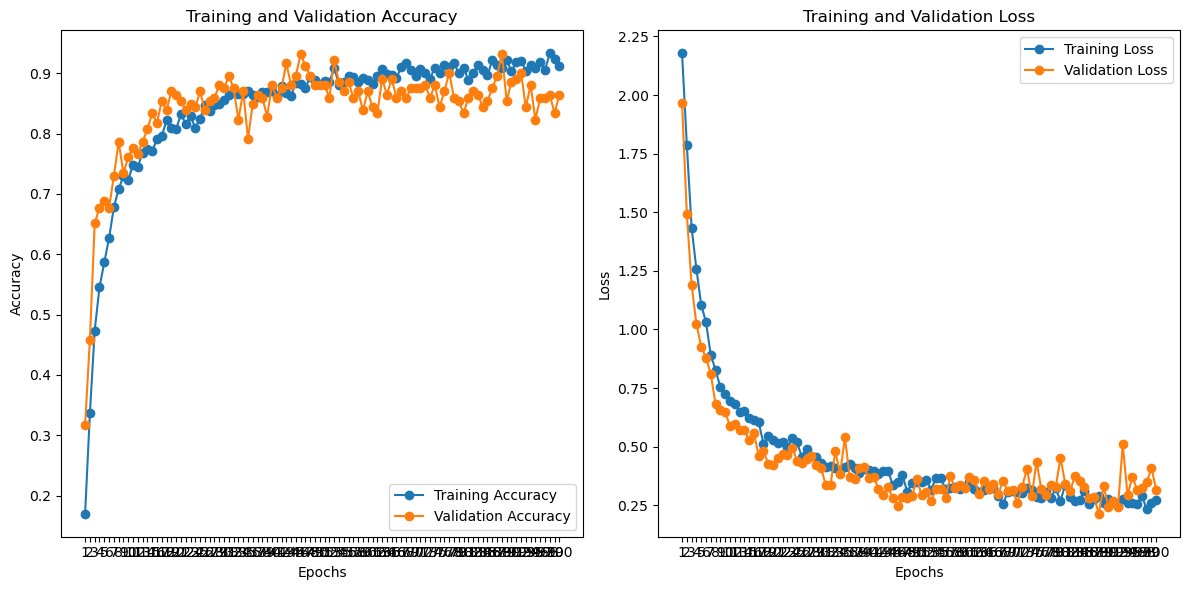

In [43]:
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy', marker='o')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, EPOCHS + 1))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1))

plt.tight_layout()
plt.show()


### Run prediction on a sample image

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [150 131 107]
  [167 147 123]
  [160 140 116]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [144 125 101]
  [146 125 106]
  [150 130 106]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [113  87  70]
  [131 114  94]
  [153 135 115]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [161 139 118]
  [164 142 121]
  [173 152 125]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [163 141 120]
  [151 129 108]
  [154 132 111]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [167 147 123]
  [162 142 120]
  [160 139 117]]]
first image to predict
actual label: Krishna_Mandir
1/1 [==============================] - 1s 837ms/step
predicted label: Krishna_Mandir
5
tf.Tensor(
[[[ 62.617188 141.30078  221.25    ]
  [ 62.570312 141.57031  220.57031 ]
  [ 63.30078  144.30078  225.30078 ]
  ...
  [ 76.19922   86.17578   90.96094 ]
  [ 80.80469   90.58594   93.24219 ]
  [ 76.46484   85.4375    90.

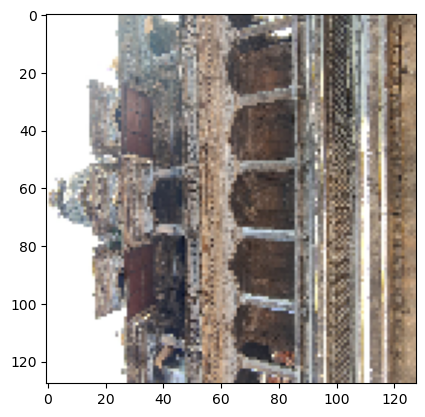

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print(first_image)
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(np.argmax(batch_prediction[0]))
    print(image_batch[0])

In [45]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the input image
img_path = r"C:\Users\pokha\monument_detection project\training\images\bouddhanath\istockphoto-1153332337-612x612.jpg"  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(128,128))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values if needed


In [46]:
predictions1 = model.predict(img_array)

1/1 [==============================] - 1s 631ms/step


In [47]:
predicted_class = np.argmax(predictions1)


In [48]:
predicted_class


6

### Write a function for inference

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 27ms/step


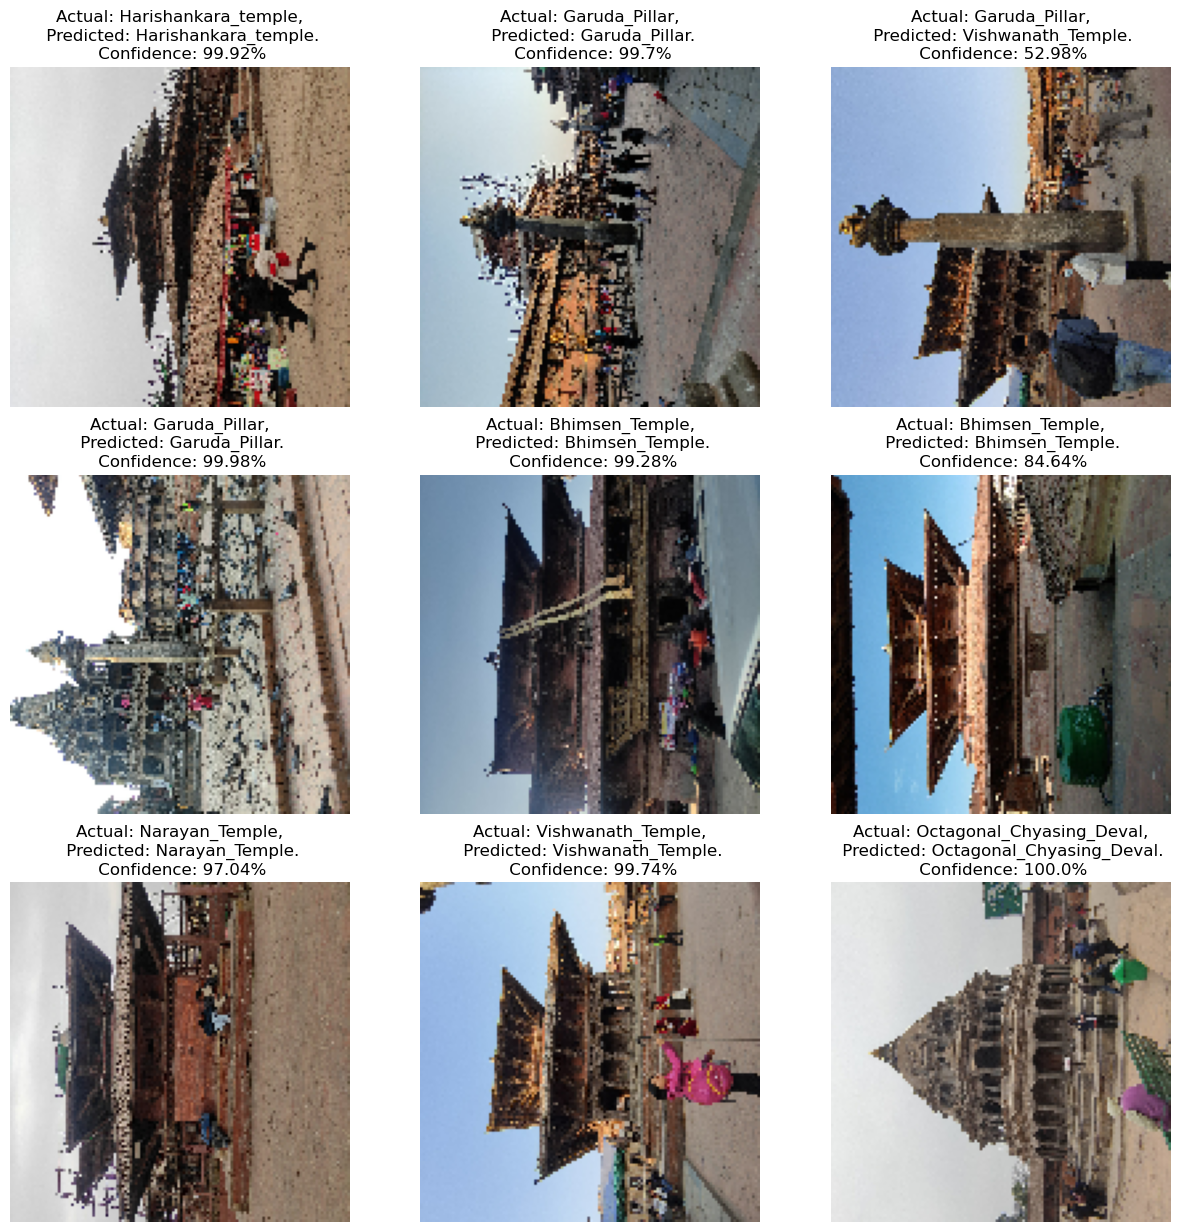

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [51]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5\assets


INFO:tensorflow:Assets written to: ../saved_models/5\assets
